## Squeeze Function WTI Cushings

![alt text](image.png)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

### Read and clean data

In [3]:
file_path = "test_datasets/Cushings(WTI) Weekly Inventories.csv"
cushing_df = pd.read_csv(file_path)
cushing_df.columns = ['Date', 'Cushing_Inventory_Thousand_Barrels']
cushing_df['Date'] = pd.to_datetime(cushing_df['Date'])
cushing_df['Cushing_Inventory_Thousand_Barrels'] = (
    cushing_df['Cushing_Inventory_Thousand_Barrels']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)
cushing_df['Cushing_Inventory_Million_Barrels'] = cushing_df['Cushing_Inventory_Thousand_Barrels'] / 1000
cushing_df = cushing_df.dropna().reset_index(drop=True)

### Define Constants

In [5]:
cushing_df.describe()

,Date,Cushing_Inventory_Thousand_Barrels,Cushing_Inventory_Million_Barrels
count,1106,1106.000000,1106.000000
mean,2014-11-10 12:00:00,35607.712477,35.607712
min,2004-04-09 00:00:00,11677.000000,11.677000
25%,2009-07-25 18:00:00,23909.750000,23.909750
50%,2014-11-10 12:00:00,33539.500000,33.539500
75%,2020-02-26 06:00:00,45618.750000,45.618750
max,2025-06-13 00:00:00,69420.000000,69.420000
std,NaN,14512.274080,14.512274


| Parameter  | Value   | Justification                                             |
| ---------- | ------- | --------------------------------------------------------- |
| $\bar{x}$  | 35      | Median and mean align around here → natural equilibrium   |
| $X_{\min}$ | 20      | Based on 25th percentile + market tightening memory       |
| $X_{\max}$ | 60–65   | Reflects observed tank-top behaviour during COVID         |
| $\sigma$   | 14.5    | Use std. dev from data for the stochastic variance        |
| $C$        | 0.5–1.0 | Calibrated to reflect transaction costs / baseline spread |


In [7]:
# Define time to maturity (assume 4 weeks = 4/52 years)
T_minus_t = 4 / 52

### Squeeze Function

$$
s(x, t) =
\frac{1}{\sqrt{2\pi \hat{\tau}} \, \sigma} \, 
\exp\left( -\frac{(y(t) - X_{\min})^2}{2\sigma^2 \hat{\tau}} \right)
-
\frac{1}{\sqrt{2\pi \hat{\tau}} \, \sigma} \, 
\exp\left( -\frac{(X_{\max} - y(t))^2}{2\sigma^2 \hat{\tau}} \right)
- C
$$

Where:

$$
y(t) = \bar{x} + (x - \bar{x}) e^{-k(T - t)}
$$

and:

$$
\hat{\tau} = \frac{1 - e^{-2k(T - t)}}{2k}
$$


In [8]:
def compute_squeeze_full(x, x_bar, k, sigma=14.5, X_min=20, X_max=65, C=0.5):
    y_t = x_bar + (x - x_bar) * np.exp(-k * T_minus_t)
    tau_hat = (1 - np.exp(-2 * k * T_minus_t)) / (2 * k)
    norm_const = 1 / (np.sqrt(2 * np.pi * tau_hat) * sigma)
    scarcity = norm_const * np.exp(-((y_t - X_min) ** 2) / (2 * sigma**2 * tau_hat))
    glut = norm_const * np.exp(-((X_max - y_t) ** 2) / (2 * sigma**2 * tau_hat))
    return scarcity - glut - C

In [10]:
def interactive_squeeze(x_bar=35.0, k=1.0):
    x_data = cushing_df['Cushing_Inventory_Million_Barrels']
    squeeze_signal = compute_squeeze_full(x_data, x_bar=x_bar, k=k)

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Inventory (Million Barrels)", color='slateblue')
    ax1.plot(cushing_df['Date'], x_data, color='slateblue', label="Inventory")
    ax1.tick_params(axis='y', labelcolor='slateblue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Squeeze Signal", color='darkred')
    ax2.plot(cushing_df['Date'], squeeze_signal, color='darkred', linestyle='--', label="Squeeze Signal")
    ax2.axhline(0, color='gray', linestyle=':')
    ax2.tick_params(axis='y', labelcolor='darkred')

    fig.tight_layout()
    plt.title("Full Squeeze Function Overlay (Virtual Barrels Eq. 3.16)")
    plt.grid(True)
    plt.show()

interact(interactive_squeeze,
         x_bar=FloatSlider(min=30.0, max=60.0, step=0.5, value=35.0, description='Equilibrium x̄'),
         k=FloatSlider(min=1, max=10.0, step=0.5, value=1, description='Mean Reversion k'))

interactive(children=(FloatSlider(value=35.0, description='Equilibrium x̄', max=60.0, min=30.0, step=0.5), Flo…

<function __main__.interactive_squeeze(x_bar=35.0, k=1.0)>

### Slow vs Fast mean reversion

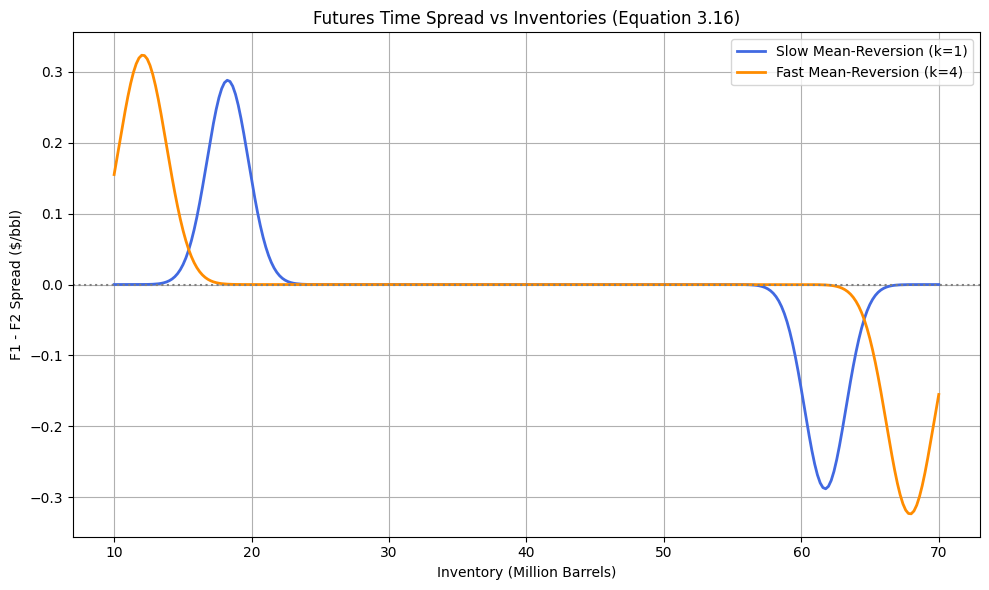

In [11]:
inventory = np.linspace(10, 70, 300)
X_min = 20
X_max = 60
x_bar = 40
sigma = 5
T_minus_t = 1 / 12
C = 0.0

def squeeze_eq(inventory, k):
    y_t = x_bar + (inventory - x_bar) * np.exp(-k * T_minus_t)
    tau_hat = (1 - np.exp(-2 * k * T_minus_t)) / (2 * k)
    norm_const = 1 / (np.sqrt(2 * np.pi * tau_hat) * sigma)
    scarcity = norm_const * np.exp(-((y_t - X_min) ** 2) / (2 * sigma**2 * tau_hat))
    glut = norm_const * np.exp(-((X_max - y_t) ** 2) / (2 * sigma**2 * tau_hat))
    return scarcity - glut - C

slow_spread = squeeze_eq(inventory, k=1)
fast_spread = squeeze_eq(inventory, k=4)

plt.figure(figsize=(10, 6))
plt.plot(inventory, slow_spread, label='Slow Mean-Reversion (k=1)', color='royalblue', linewidth=2)
plt.plot(inventory, fast_spread, label='Fast Mean-Reversion (k=4)', color='darkorange', linewidth=2)
plt.axhline(0, color='gray', linestyle=':')
plt.title("Futures Time Spread vs Inventories (Equation 3.16)")
plt.xlabel("Inventory (Million Barrels)")
plt.ylabel("F1 - F2 Spread ($/bbl)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()